# Bike highways - revisit manually

After AWS and PyCaret it's still nice to do a bit of predicting ourselves. Let's load the same dataset (again) and see of any of the models we saw will be able to provide a good prediction.

In [2]:
import pandas as pd

df = pd.read_csv('files/bike_counters_data/Measured data-nl-Geel_FMN GV 21 Geel.csv')

df["date_time"] = df["Datum"] + " " + df["Tijd"]
df["date_time"] = pd.to_datetime(df["date_time"])
df = df.set_index("date_time")
df = df[["Aantal fietsers"]]
df.head()

,Aantal fietsers
date_time,
2020-02-14 00:00:00,0
2020-02-14 01:00:00,0
2020-02-14 02:00:00,0
2020-02-14 03:00:00,2
2020-02-14 04:00:00,0


First, group by month and plot the data.

<Axes: xlabel='date_time'>

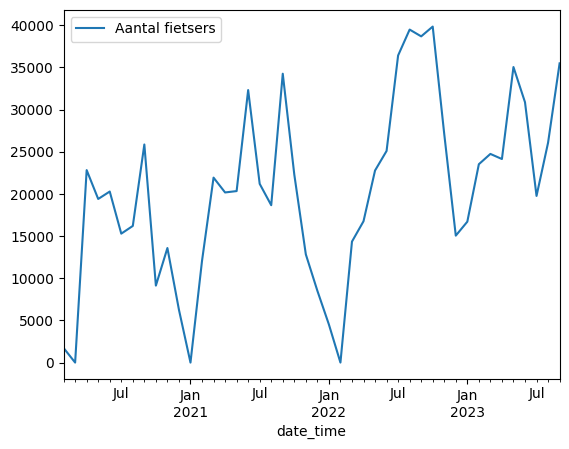

In [3]:
df_time_month = df.loc[ df["Aantal fietsers"] >= 30 ].resample('M').sum().reset_index().set_index(['date_time'])
df_time_month.plot()

Next, calculate the autocorrection on this dataset. This should show us any seasonality that is in there.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

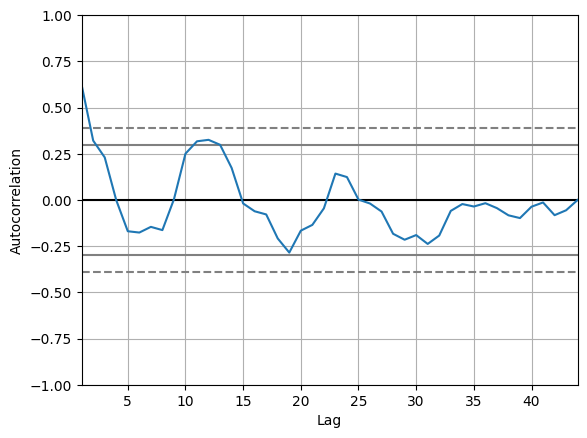

In [4]:
# DELETE

pd.plotting.autocorrelation_plot(df_time_month['Aantal fietsers'])

It's not as obvious as the example dataset, but there is a definite spike at 12 and 24 (months). And this is significant because we only have three years worth of data.

What is we group the data by day?

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

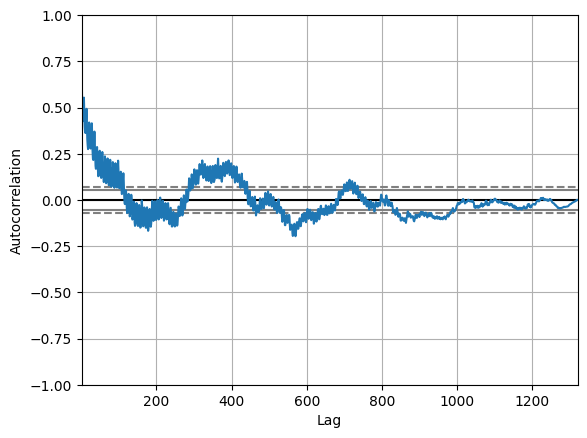

In [5]:
df_time_day = df.loc[ df["Aantal fietsers"] >= 30 ].resample('D').sum().reset_index().set_index(['date_time'])
# df_time_day.plot()
pd.plotting.autocorrelation_plot(df_time_day['Aantal fietsers'])

The same spike at 365 and 730! But not much higher, so we could simply keep on working with the monthly data...

## Arima

* [Try this one](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)
* [Or this one](https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/)

Both require the statsmodel package to check for stationarity. You can install it using pip. If you use the bottom one you'll also need pmdarima. The solution uses the bottom one.

In [56]:
# %pip install statsmodels
# %pip install pmdarima

Now run the model. Easiest way to go about it is to reload the excel file, set the date as index, drop all columns besides "Aantal fietsers" and resample as months.

Then do a seasonal decompose.

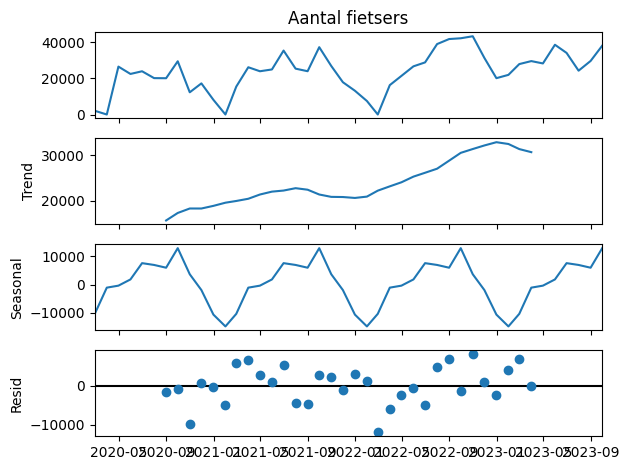

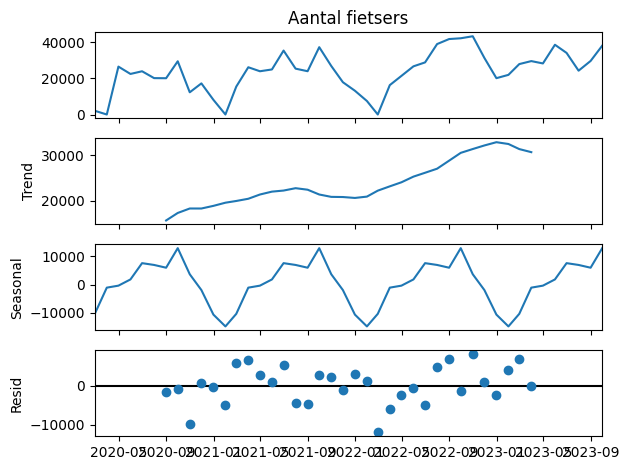

In [54]:
# DELETE

from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv('files/bike_counters_data/Measured data-nl-Geel_FMN GV 21 Geel.csv')[ ["Datum", "Aantal fietsers"] ]
df = df.loc[ df['Aantal fietsers'] > 1 ]
df["Datum"] = pd.to_datetime(df["Datum"])
df1 = df.resample('M', on='Datum').sum()

result = seasonal_decompose(df1['Aantal fietsers'],  model ='additive')
result.plot()

Next, try to fit an Arima model on your data.

In [57]:
# DELETE

from pmdarima import auto_arima

import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(df1['Aantal fietsers'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=674.352, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=687.170, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=676.432, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=676.697, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=693.746, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=684.039, Time=0.09 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=675.745, Time=0.32 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=675.889, Time=0.46 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=675.682, Time=0.20 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=677.590, Time=1.00 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=674.317, Time=0.17 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=683.258, Time=0.02 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=676.113, Time=0.21 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=675.914, Time=0.36 sec
 ARIMA(1,0,0)(1,1,2)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   44
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -333.159
Date:                              Tue, 17 Oct 2023   AIC                            674.317
Time:                                      16:29:46   BIC                            680.180
Sample:                                  02-29-2020   HQIC                           676.261
                                       - 09-30-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2880.9723   2812.265      1.024      0.306   -2630.965    8392.909
ar.L1          0.5588      0.351      1.590      0.112      -0.130       1.247
ma.S.L12      -0.6615      0.506     -1.307      0.191      -1.654       0.331
sigma2      9.042e+07      0.019   4.84e+09      0.000    9.04e+07    9.04e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.76   Prob(JB):                         0.86
Heteroskedasticity (H):               0.68   Skew:                            -0.16
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  2e+26. Standard errors may be unstable.
"""

Train a model using the parameters you found.

In [60]:
# DELETE

# Split data into train / test sets 
train = df1.iloc[:len(df1)-12] 
test = df1.iloc[len(df1)-12:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(1, 0, 0)x(0, 1, [1], 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train['Aantal fietsers'],  
                order = (1, 0, 0),  
                seasonal_order =(0, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      Aantal fietsers   No. Observations:                   32
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -210.863
Date:                              Tue, 17 Oct 2023   AIC                            427.727
Time:                                      16:32:46   BIC                            430.714
Sample:                                  02-29-2020   HQIC                           428.310
                                       - 09-30-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8357      0.218      3.826      0.000       0.408       1.264
ma.S.L12      -0.6473      0.527     -1.228      0.219      -1.680       0.386
sigma2      9.508e+07    3.8e-09    2.5e+16      0.000    9.51e+07    9.51e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.26   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.26   Prob(JB):                         0.70
Heteroskedasticity (H):               0.80   Skew:                            -0.32
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.49e+32. Standard errors may be unstable.
"""

Finally, test the trained model.

<Axes: xlabel='Datum'>

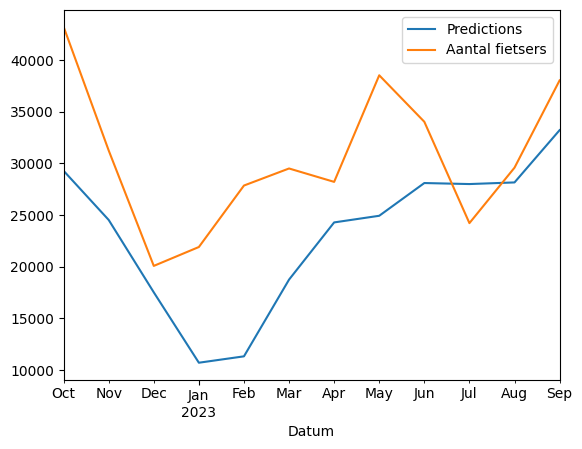

In [62]:
# DELETE

start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test['Aantal fietsers'].plot(legend = True) 


And what are the MSE and RMSE of our model? We know by the graph it won't be great, but still doable, no?

In [65]:


# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
  
# Calculate root mean squared error 
print(rmse(test["Aantal fietsers"], predictions))
  
# Calculate mean squared error 
print(mean_squared_error(test["Aantal fietsers"], predictions) )


9294.621694002642
86389992.43462454
